# 1. Import Ntuple and DecayHash

In [1]:
import root_pandas
import uproot
import decayHash
import basf2 as b2
from decayHash import DecayHashMap
import sys
import numpy as np
import ROOT
import pandas

# read in root-file as a pandas dataframe
filename='../Ntuples/bengal_mu_50k.root'
decayhash='../Ntuples/hashmap_bengal_mu_50k.root'
#data = uproot.open(filename)['B0'].arrays(library="pd")
data = root_pandas.read_root(filename,key='B0')
MC_tau_B = root_pandas.read_root(filename,key='tau_B')
MC_nu_B = root_pandas.read_root(filename,key='nu_tau_B')
MC_nu_tau_tau = root_pandas.read_root(filename,key='nu_tau_tau')
MC_nu_mu_tau = root_pandas.read_root(filename,key='nu_mu_tau')
hashmap = DecayHashMap(decayhash, removeRadiativeGammaFlag=False)
hashmap2 = DecayHashMap(decayhash, removeRadiativeGammaFlag=True)

Welcome to JupyROOT 6.24/06


In [3]:
data.nElectrons90.value_counts()

0    12682
1     2232
2      154
3        1
Name: nElectrons90, dtype: int64

In [4]:
data.B0_roeMC_MissFlags_my_mask.value_counts()

9.0       1580
1.0       1299
521.0      669
513.0      561
1025.0     536
          ... 
1674.0       1
355.0        1
795.0        1
129.0        1
1567.0       1
Name: B0_roeMC_MissFlags_my_mask, Length: 281, dtype: int64

In [ ]:
import pandas
pandas.set_option('display.max_rows', None)
print(data.isna().sum())

### MC

In [2]:
# select events where B_tag does not SL decay
MC_tau_B_1 = MC_tau_B[['__event__','__candidate__','E','px','py','pz','M']]
MC_nu_B_1 = MC_nu_B[['__event__','__candidate__','E','px','py','pz','M']]
MC_nu_tau_tau_1 = MC_nu_tau_tau[['__event__','__candidate__','E','px','py','pz','M']]
MC_nu_mu_tau_1 = MC_nu_mu_tau[['__event__','__candidate__','E','px','py','pz','M']]

# combine and keep events with inner products of the 4 df
MC_tau = pandas.merge(MC_nu_tau_tau_1,MC_nu_mu_tau_1,on=['__event__','__candidate__'],validate='1:1',suffixes=['_nu_tau','_nu_mu'])
MC_B = pandas.merge(MC_tau_B_1,MC_nu_B_1,on=['__event__','__candidate__'],validate='1:1',suffixes=['_tau','_nu'])
MC = pandas.merge(MC_B,MC_tau,on=['__event__','__candidate__'],validate='1:1').query('__candidate__==0')
# calculate the MC MM2 and q2
MC.eval('MM2_MC = (E_nu + E_nu_tau + E_nu_mu)**2 - (px_nu + px_nu_tau + px_nu_mu)**2 - (py_nu + py_nu_tau + py_nu_mu)**2 - (pz_nu + pz_nu_tau + pz_nu_mu)**2', inplace=True)
MC.eval('q2_MC = M_tau**2 + 2*(E_tau*E_nu - px_tau*px_nu - py_tau*py_nu - pz_tau*pz_nu)', inplace=True)

# 2. Add DecayMode column to the Ntuple

In [3]:
from collections import OrderedDict

def found(modes,row):
    for mode in modes:
        if mode.startswith(str(int(row['B0_mcPDG']))):
            decaytree = ROOT.Belle2.DecayTree(mode)
            if hashmap2.get_original_decay(row["B0_DecayHash"],row["B0_DecayHashEx"]).find_decay(decaytree):
                return True
        else:
            continue
    return False

def decay_mode(row):
    for name,modes in mode_dict.items():
        if found(modes,row):
            return name
    return 'bkg' # other_B_decay (hadronic) or hadronic_tau or other_D_decay or charged_B or continuum

# the order of keys might be important, try to keep the muon modes at the bottom for e reconstruction
# the e modes will be kept at the bottom for a muon reconstruction
mode_dict = OrderedDict()
mode_dict['sig_D_tau_nu']=['511 (-> -411 (-> 321 -211 -211) -15 (-> -11 12 -16) 16)',
                           '-511 (-> 411 (-> -321 211 211) 15 (-> 11 -12 16) -16)',
                           '511 (-> -411 (-> 321 -211 -211) -15 (-> -13 14 -16) 16)',
                           '-511 (-> 411 (-> -321 211 211) 15 (-> 13 -14 16) -16)']

mode_dict['sig_D_e_nu']=['511 (-> -411 (-> 321 -211 -211) -11 12)',
                         '-511 (-> 411 (-> -321 211 211) 11 -12)']

mode_dict['sig_Dst_tau_nu']=['511 (-> -413 (-> -411 (-> 321 -211 -211) 111) -15 (-> -11 12 -16) 16)',
                             '-511 (-> 413 (-> 411 (-> -321 211 211) 111) 15 (-> 11 -12 16) -16)',
                             '511 (-> -413 (-> -411 (-> 321 -211 -211) 111) -15 (-> -13 14 -16) 16)',
                             '-511 (-> 413 (-> 411 (-> -321 211 211) 111) 15 (-> 13 -14 16) -16)',
                             '511 (-> -413 (-> -411 (-> 321 -211 -211) 22) -15 (-> -11 12 -16) 16)',
                             '-511 (-> 413 (-> 411 (-> -321 211 211) 22) 15 (-> 11 -12 16) -16)',
                             '511 (-> -413 (-> -411 (-> 321 -211 -211) 22) -15 (-> -13 14 -16) 16)',
                             '-511 (-> 413 (-> 411 (-> -321 211 211) 22) 15 (-> 13 -14 16) -16)']

mode_dict['sig_Dst_e_nu']=['511 (-> -413 (-> -411 (-> 321 -211 -211) 111) -11 12)',
                           '511 (-> -413 (-> -411 (-> 321 -211 -211) 22) -11 12)',
                           '-511 (-> 413 (-> 411 (-> -321 211 211) 111) 11 -12)',
                           '-511 (-> 413 (-> 411 (-> -321 211 211) 22) 11 -12)']

mode_dict['all_Dstst_tau_nu']=['511 (-> -10413 -15 (-> -11 12 -16) 16)','-511 (-> 10413 15 (-> 11 -12 16) -16)',
                               '511 (-> -10411 -15 (-> -11 12 -16) 16)','-511 (-> 10411 15 (-> 11 -12 16) -16)',
                               '511 (-> -20413 -15 (-> -11 12 -16) 16)','-511 (-> 20413 15 (-> 11 -12 16) -16)',
                               '511 (-> -415 -15 (-> -11 12 -16) 16)',  '-511 (-> 415 15 (-> 11 -12 16) -16)',
                               '521 (-> -10423 -15 (-> -11 12 -16) 16)','-521 (-> 10423 15 (-> 11 -12 16) -16)',
                               '521 (-> -10421 -15 (-> -11 12 -16) 16)','-521 (-> 10421 15 (-> 11 -12 16) -16)',
                               '521 (-> -20423 -15 (-> -11 12 -16) 16)','-521 (-> 20423 15 (-> 11 -12 16) -16)',
                               '521 (-> -425 -15 (-> -11 12 -16) 16)',  '-521 (-> 425 15 (-> 11 -12 16) -16)',
                               '511 (-> -10413 -15 (-> -13 14 -16) 16)','-511 (-> 10413 15 (-> 13 -14 16) -16)',
                               '511 (-> -10411 -15 (-> -13 14 -16) 16)','-511 (-> 10411 15 (-> 13 -14 16) -16)',
                               '511 (-> -20413 -15 (-> -13 14 -16) 16)','-511 (-> 20413 15 (-> 13 -14 16) -16)',
                               '511 (-> -415 -15 (-> -13 14 -16) 16)',  '-511 (-> 415 15 (-> 13 -14 16) -16)',
                               '521 (-> -10423 -15 (-> -13 14 -16) 16)','-521 (-> 10423 15 (-> 13 -14 16) -16)',
                               '521 (-> -10421 -15 (-> -13 14 -16) 16)','-521 (-> 10421 15 (-> 13 -14 16) -16)',
                               '521 (-> -20423 -15 (-> -13 14 -16) 16)','-521 (-> 20423 15 (-> 13 -14 16) -16)',
                               '521 (-> -425 -15 (-> -13 14 -16) 16)',  '-521 (-> 425 15 (-> 13 -14 16) -16)']

mode_dict['all_Dstst_e_nu']=['511 (-> -10413 -11 12)','-511 (-> 10413 11 -12)',
                             '511 (-> -10411 -11 12)','-511 (-> 10411 11 -12)',
                             '511 (-> -20413 -11 12)','-511 (-> 20413 11 -12)',
                             '511 (-> -415 -11 12)',  '-511 (-> 415 11 -12)',
                             '511 (-> -411 221 -11 12)','-511 (-> 411 221 11 -12)',
                             '511 (-> -411 111 -11 12)','-511 (-> 411 111 11 -12)',
                             '511 (-> -411 111 111 -11 12)','-511 (-> 411 111 111 11 -12)',
                             '511 (-> -411 211 -211 -11 12)','-511 (-> 411 211 -211 11 -12)',
                             '511 (-> -413 221 -11 12)','-511 (-> 413 221 11 -12)',
                             '511 (-> -413 111 -11 12)','-511 (-> 413 111 11 -12)',
                             '511 (-> -413 111 111 -11 12)','-511 (-> 413 111 111 11 -12)',
                             '511 (-> -413 211 -211 -11 12)','-511 (-> 413 211 -211 11 -12)',
                             '511 (-> -421 -211 -11 12)','-511 (-> 421 211 11 -12)',
                             '511 (-> -423 -211 -11 12)','-511 (-> 423 211 11 -12)',
                             '521 (-> -10423 -11 12)','-521 (-> 10423 11 -12)',
                             '521 (-> -10421 -11 12)','-521 (-> 10421 11 -12)',
                             '521 (-> -20423 -11 12)','-521 (-> 20423 11 -12)',
                             '521 (-> -425 -11 12)',  '-521 (-> 425 11 -12)',
                             '521 (-> -411 211 -11 12)','-521 (-> 411 211 11 -12)',
                             '521 (-> -411 211 111 -11 12)','-521 (-> 411 211 111 11 -12)',
                             '521 (-> -413 211 -11 12)','-521 (-> 413 211 11 -12)',
                             '521 (-> -413 211 111 -11 12)','-521 (-> 413 211 111 11 -12)']

mode_dict['sig_D_mu_nu']=['511 (-> -411 (-> 321 -211 -211) -13 14)',
                          '-511 (-> 411 (-> -321 211 211) 13 -14)']

mode_dict['sig_Dst_mu_nu']=['511 (-> -413 (-> -411 (-> 321 -211 -211) 111) -13 14)',
                           '511 (-> -413 (-> -411 (-> 321 -211 -211) 22) -13 14)',
                           '-511 (-> 413 (-> 411 (-> -321 211 211) 111) 13 -14)',
                           '-511 (-> 413 (-> 411 (-> -321 211 211) 22) 13 -14)']

mode_dict['all_Dstst_mu_nu']=['511 (-> -10413 -13 14)','-511 (-> 10413 13 -14)',
                              '511 (-> -10411 -13 14)','-511 (-> 10411 13 -14)',
                              '511 (-> -20413 -13 14)','-511 (-> 20413 13 -14)',
                              '511 (-> -415 -13 14)',  '-511 (-> 415 13 -14)',
                              '511 (-> -411 221 -13 14)','-511 (-> 411 221 13 -14)',
                              '511 (-> -411 111 -13 14)','-511 (-> 411 111 13 -14)',
                              '511 (-> -411 111 111 -13 14)','-511 (-> 411 111 111 13 -14)',
                              '511 (-> -411 211 -211 -13 14)','-511 (-> 411 211 -211 13 -14)',
                              '511 (-> -413 221 -13 14)','-511 (-> 413 221 13 -14)',
                              '511 (-> -413 111 -13 14)','-511 (-> 413 111 13 -14)',
                              '511 (-> -413 111 111 -13 14)','-511 (-> 413 111 111 13 -14)',
                              '511 (-> -413 211 -211 -13 14)','-511 (-> 413 211 -211 13 -14)',
                              '511 (-> -421 -211 -13 14)','-511 (-> 421 211 13 -14)',
                              '511 (-> -423 -211 -13 14)','-511 (-> 423 211 13 -14)',
                              '521 (-> -10423 -13 14)','-521 (-> 10423 13 -14)',
                              '521 (-> -10421 -13 14)','-521 (-> 10421 13 -14)',
                              '521 (-> -20423 -13 14)','-521 (-> 20423 13 -14)',
                              '521 (-> -425 -13 14)',  '-521 (-> 425 13 -14)',
                              '521 (-> -411 211 -13 14)','-521 (-> 411 211 13 -14)',
                              '521 (-> -411 211 111 -13 14)','-521 (-> 411 211 111 13 -14',
                              '521 (-> -413 211 -13 14)','-521 (-> 413 211 13 -14)',
                              '521 (-> -413 211 111 -13 14)','-521 (-> 413 211 111 13 -14)']

In [4]:
data['DecayMode'] = data.apply(decay_mode, axis=1).astype('category') #axis=0 will allow the application to be done at a column

data['B0_isSignal'] = data['B0_isSignal'].fillna(-1)
data['D_isSignal'] = data['D_isSignal'].fillna(-1)
data['mu_isSignal'] = data['mu_isSignal'].fillna(-1)
data['B0_mcPDG'] = data['B0_mcPDG'].fillna(0)
data['isSignal'] = 1.0
data.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
data.eval('p_D_l = D_CMS_p + mu_CMS_p', inplace=True)

# Calculate the q2 in different ways
data.eval('q2_SigOnly = (0.5*Ecms - D_CMS_E)**2 - D_CMS_px**2 - D_CMS_py**2 - D_CMS_pz**2', inplace=True)
data.eval('MM2_SigOnly = (0.5*Ecms - D_CMS_E - mu_CMS_E)**2 - (D_CMS_px + mu_CMS_px)**2 - (D_CMS_py + mu_CMS_py)**2 - (D_CMS_pz + mu_CMS_pz)**2', inplace=True)

data.DecayMode.value_counts()

sig_D_tau_nu    15069
Name: DecayMode, dtype: int64

In [ ]:
cut='B0_TauminusMode==-1'#'DecayMode=="bkg" and B0_isContinuumEvent!=1'
candidate12 = df_cut.query(cut).iloc[2][['B0_DecayHash', "B0_DecayHashEx"]].values

# print the original decay as simulated in MC with removed Bremsstrahlung gammas
print("Monte Carlo Decay with removed Bremsstrahlung gammas: ")
org2 = hashmap2.get_original_decay(*candidate12)
print(org2.to_string())

In [5]:
samples = {}
names = ['BC','AC']
cut = 'D_vtxReChi2<13 and B0_vtxReChi2<14 and 5<B0_roeMbc_my_mask and \
    -5<B0_roeDeltae_my_mask<2 and 4.3<B0_CMS2_weMbc and -3<B0_CMS0_weDeltae<2 and \
    abs(B0_roeCharge_my_mask)<3 and -3.2<B0_deltaE<0 and mu_p>0.6 and \
    nElectrons90+nMuons90==1'
for name in names:
    if name == 'BC':
        df = data.copy()
    else:
        df = data.query(cut).copy()
    
    print(f'{name} before BCS')
    print(df.DecayMode.value_counts())

    df_bestSelected=df.loc[df.groupby(['__experiment__','__run__','__event__','__production__']).B_D_ReChi2.idxmin()]

    print(f'{name} after BCS')
    print(df_bestSelected.DecayMode.value_counts())
    
    df_merged = pandas.merge(df_bestSelected,MC,on=['__event__'],validate='1:1')
    samples[name] = df_merged

BC before BCS
sig_D_tau_nu    15069
Name: DecayMode, dtype: int64
BC after BCS
sig_D_tau_nu    11298
Name: DecayMode, dtype: int64
AC before BCS
sig_D_tau_nu    6706
Name: DecayMode, dtype: int64
AC after BCS
sig_D_tau_nu    6052
Name: DecayMode, dtype: int64


# 4. Get fitting templates

In [ ]:
# apply BDTs
# plot mm2, mm2 vs p_D_l
# save the templates

In [8]:
import basf2_mva
import pandas

identifier_1 = '/home/belle/zhangboy/R_D/Generic_MC14rd/Continuum_Suppression/MVA1_FastBDT.xml'
test_1 = '../Ntuples/MC_eidglobal_10k_cut.root'
output_file_1 = '../Ntuples/MC_eidglobal_10k_MVA1.root'

identifier_1_5 = '/home/belle/zhangboy/R_D/Generic_MC14rd/B_bkg_Suppression/MVA1_5/MVA1_5_FastBDT.xml'
test_1_5 = '../Ntuples/MC_eidglobal_10k_cut.root'
output_file_1_5 = '../Ntuples/MC_eidglobal_10k_MVA1_5.root'

output_file_1_5_applied = '../Ntuples/MC_eidglobal_10k_MVA1_5_applied.root'

identifier_2_1 = '/home/belle/zhangboy/R_D/Generic_MC14rd/B_bkg_Suppression/MVA2/MVA2_1_FastBDT.xml'
test_2_1 = output_file_1_5_applied
output_file_2_1 = '../Ntuples/MC_eidglobal_10k_MVA2_1.root'
output_file_2_1_applied = '../Ntuples/MC_eidglobal_10k_MVA2_1_applied.root'

In [9]:
# apply CS BDT identifier_1, merge data file and mva output, rename the column
basf2_mva.expert(basf2_mva.vector(identifier_1),  # weightfile
                 basf2_mva.vector(test_1),
                 'B0', output_file_1)

df1 = df_cut.drop_duplicates(subset=['__experiment__','__run__','__event__','__production__','__candidate__']).reset_index(drop=True)
df2 = root_pandas.read_root(output_file_1)
print(len(df1)==len(df2))
df_1 = pandas.concat([df1,df2],axis=1)

df_1=df_1.rename(columns={"__slhome__slbelle__slzhangboy__slR_D__slGeneric_MC14rd__slContinuum_Suppression__slMVA1_FastBDT__ptxml": "MVA1_output"})
df_1=df_1.drop(columns=['__slhome__slbelle__slzhangboy__slR_D__slGeneric_MC14rd__slContinuum_Suppression__slMVA1_FastBDT__ptxml_isSignal'])

# apply BDT 1_5 identifier_1_5, merge, rename, change the output type, save
basf2_mva.expert(basf2_mva.vector(identifier_1_5),  # weightfile
                 basf2_mva.vector(test_1_5),
                 'B0', output_file_1_5)

df3 = root_pandas.read_root(output_file_1_5)
print(len(df_1)==len(df3))
df_1_5 = pandas.concat([df_1,df3],axis=1)

df_1_5=df_1_5.rename(columns={"__slhome__slbelle__slzhangboy__slR_D__slGeneric_MC14rd__slB_bkg_Suppression__slMVA1_5__slMVA1_5_FastBDT__ptxml": "MVA1_5_output"})
df_1_5=df_1_5.drop(columns=['__slhome__slbelle__slzhangboy__slR_D__slGeneric_MC14rd__slB_bkg_Suppression__slMVA1_5__slMVA1_5_FastBDT__ptxml_isSignal'])

df_1_5.MVA1_5_output=np.float64(df_1_5.MVA1_5_output)
print(type(df_1_5.MVA1_5_output[0]))
print(type(df_1_5.isSignal[0]))

df_1_5.to_root(output_file_1_5_applied, key='B0')

# apply BDT 2_1 identifier_2_1, merge, rename, save
basf2_mva.expert(basf2_mva.vector(identifier_2_1),  # weightfile
                 basf2_mva.vector(test_2_1),
                 'B0', output_file_2_1)

df4 = root_pandas.read_root(output_file_2_1)
print(len(df_1_5)==len(df4))
df_2_1 = pandas.concat([df_1_5, df4],axis=1)
print(len(df_1_5)==len(df_2_1))

df_2_1=df_2_1.rename(columns={"__slhome__slbelle__slzhangboy__slR_D__slGeneric_MC14rd__slB_bkg_Suppression__slMVA2__slMVA2_1_FastBDT__ptxml": "MVA2_1_output"})
df_2_1=df_2_1.drop(columns=['__slhome__slbelle__slzhangboy__slR_D__slGeneric_MC14rd__slB_bkg_Suppression__slMVA2__slMVA2_1_FastBDT__ptxml_isSignal'])

df_2_1.to_root(output_file_2_1_applied, key='B0')

[INFO] Elapsed application time in ms 19.8755 for MVA1_FastBDT.xml
[WARNING] String passed to makeROOTCompatible contains double-underscore __, which is used internally for escaping special characters. It is recommended to avoid this. However escaping a string twice with makeROOTCompatible is safe, but will print this warning. Passed string: __slhome__slbelle__slzhangboy__slR_D__slGeneric_MC14rd__slContinuum_Suppression__slMVA1_FastBDT__ptxml_isSignal
False
[INFO] Elapsed application time in ms 17.8737 for MVA1_5_FastBDT.xml
[WARNING] String passed to makeROOTCompatible contains double-underscore __, which is used internally for escaping special characters. It is recommended to avoid this. However escaping a string twice with makeROOTCompatible is safe, but will print this warning. Passed string: __slhome__slbelle__slzhangboy__slR_D__slGeneric_MC14rd__slB_bkg_Suppression__slMVA1_5__slMVA1_5_FastBDT__ptxml_isSignal
True
<class 'numpy.float64'>
<class 'numpy.float64'>


/cvmfs/belle.cern.ch/el7/externals/v01-10-02/Linux_x86_64/common/lib/python3.8/site-packages/root_numpy/_tree.py:575: UserWarning: converter for dtype('O') is not implemented (skipping)
  cobj = _librootnumpy.array2tree_toCObj(arr, name=name, tree=incobj)


[INFO] Elapsed application time in ms 16.9586 for MVA2_1_FastBDT.xml
[WARNING] String passed to makeROOTCompatible contains double-underscore __, which is used internally for escaping special characters. It is recommended to avoid this. However escaping a string twice with makeROOTCompatible is safe, but will print this warning. Passed string: __slhome__slbelle__slzhangboy__slR_D__slGeneric_MC14rd__slB_bkg_Suppression__slMVA2__slMVA2_1_FastBDT__ptxml_isSignal
True
True


In [10]:
df_2_1.columns
len(df_2_1)

1589

In [11]:
df_bestSelected=df_2_1.loc[df_2_1.groupby(['__experiment__','__run__','__event__','__production__']).B_D_ReChi2.idxmin()]

In [6]:
import pandas
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
plt.style.use('belle2')
# plot mm2, mm2 vs p_D_l
# save the templates

In [7]:
# Signal components
sig_D_mu_nu=samples['AC'].query('DecayMode=="sig_D_mu_nu" and B0_mcErrors<16 and abs(D_mcPDG)==411 and abs(mu_genMotherPDG)==511').copy()
sig_D_tau_nu=samples['AC'].query('DecayMode=="sig_D_tau_nu" and B0_mcErrors<32 and abs(D_mcPDG)==411 and abs(mu_genMotherPDG)==15').copy()
sig_Dst_mu_nu=samples['AC'].query('DecayMode=="sig_Dst_mu_nu" and B0_mcErrors<64 and abs(D_mcPDG)==411 and abs(mu_genMotherPDG)==511').copy()
sig_Dst_tau_nu=samples['AC'].query('DecayMode=="sig_Dst_tau_nu" and B0_mcErrors<64 and abs(D_mcPDG)==411 and abs(mu_genMotherPDG)==15').copy()
all_Dstst_mu_nu=samples['AC'].query('DecayMode=="all_Dstst_mu_nu" and abs(D_mcPDG)==411 and \
((B0_mcErrors<64 and abs(mu_genMotherPDG)==511) or (B0_mcErrors<512 and abs(mu_genMotherPDG)==521))').copy()
all_Dstst_tau_nu=samples['AC'].query('DecayMode=="all_Dstst_tau_nu" and abs(D_mcPDG)==411 and abs(mu_genMotherPDG)==15 and \
((B0_mcErrors<64 and abs(B0_mcPDG)==511) or (B0_mcErrors<512 and abs(B0_mcPDG)==521))').copy()

#sig_D_mu_nu=samples['AC'].query('DecayMode=="sig_D_mu_nu" and B0_mcErrors<16').copy()
#sig_Dst_mu_nu=samples['AC'].query('DecayMode=="sig_Dst_mu_nu" and (16<=B0_mcErrors<32 or B0_mcErrors<8)').copy()
#all_Dstst_mu_nu=samples['AC'].query('DecayMode=="all_Dstst_mu_nu" and (16<=B0_mcErrors<64 or B0_mcErrors<8)').copy()

# Bkg components
bkg_fakeD = samples['AC'].query('abs(D_mcPDG)!=411 and B0_mcErrors!=512 and B0_isContinuumEvent!=1').copy()
bkg_fakeTracksClusters = samples['AC'].query('B0_mcErrors==512 and B0_isContinuumEvent!=1').copy()
bkg_fakeDTC = pandas.concat([bkg_fakeD, bkg_fakeTracksClusters])

bkg_combinatorial = samples['AC'].query('B0_mcPDG==300553 and abs(D_mcPDG)==411 and B0_mcErrors!=512 and B0_isContinuumEvent!=1').copy()
bkg_sigOtherBDTaudecay = samples['AC'].query('(DecayMode=="bkg" or DecayMode=="sig_D_e_nu" or DecayMode=="sig_Dst_e_nu" or DecayMode=="all_Dstst_e_nu") and \
B0_mcPDG!=300553 and abs(D_mcPDG)==411 and B0_mcErrors!=512 and B0_isContinuumEvent!=1').copy()
bkg_fakeB = pandas.concat([bkg_combinatorial, bkg_sigOtherBDTaudecay])

bkg_continuum = samples['AC'].query('B0_isContinuumEvent==1').copy()

bkg_others = pandas.concat([samples['AC'],
                           sig_D_mu_nu,
                           sig_D_tau_nu,
                           sig_Dst_mu_nu,
                           sig_Dst_tau_nu,
                           all_Dstst_mu_nu,
                           all_Dstst_tau_nu,
                           bkg_fakeDTC,
                           bkg_fakeB,
                           bkg_continuum]).drop_duplicates(keep=False)
# Weird! the bkg_others contains some events with
# correct sig decay hash chain and correct B0_mcPDG, D_mcPDG, e_genMotherPDG,
# but with 128< B0_mcErrors < 256 (misID)


def statistics(df):
    counts=df.count()
    mean=df.mean()
    std=df.std()
    return f'''counts = %d \nmean = %5.3f \nstd = %5.3f''' %(counts,mean,std)

kwarg={'bins':50, 'histtype':'step','lw':2}

    
def plot_projection(cut,variable):
    (counts1, bins1) = np.histogram(sig_D_tau_nu.query(cut)[variable], bins=50)
    (counts2, bins2) = np.histogram(sig_Dst_tau_nu.query(cut)[variable], bins=50)
    factor = 1
    plt.hist(bins1[:-1], bins1, weights=factor*counts1,label=f'D_tau_nu \n{statistics(sig_D_tau_nu.query(cut)[variable])}',alpha=0.6)
    sig_D_mu_nu.query(cut)[variable].hist(label=f'D_mu_nu \n{statistics(sig_D_mu_nu.query(cut)[variable])}',**kwarg)
    
    plt.hist(bins2[:-1], bins2, weights=factor*counts2,label=f'Dst_tau_nu \n{statistics(sig_Dst_tau_nu.query(cut)[variable])}',alpha=0.6,histtype='step',lw=2)
    sig_Dst_mu_nu.query(cut)[variable].hist(label=f'Dst_mu_nu \n{statistics(sig_Dst_mu_nu.query(cut)[variable])}',**kwarg)
    all_Dstst_tau_nu.query(cut)[variable].hist(label=f'all_Dstst_tau_nu \n{statistics(all_Dstst_tau_nu.query(cut)[variable])}',**kwarg)
    all_Dstst_mu_nu.query(cut)[variable].hist(label=f'all_Dstst_mu_nu \n{statistics(all_Dstst_mu_nu.query(cut)[variable])}',**kwarg)
    bkg_fakeDTC.query(cut)[variable].hist(label=f'bkg_fakeD_Tracks_Clusters \n{statistics(bkg_fakeDTC.query(cut)[variable])}',**kwarg)
    bkg_fakeB.query(cut)[variable].hist(label=f'bkg_comb_wrongDecay \n{statistics(bkg_fakeB.query(cut)[variable])}',**kwarg)
    bkg_continuum.query(cut)[variable].hist(label=f'bkg_continuum \n{statistics(bkg_continuum.query(cut)[variable])}',**kwarg)
    bkg_others.query(cut)[variable].hist(label=f'bkg_others \n{statistics(bkg_others.query(cut)[variable])}',**kwarg)
    plt.legend(bbox_to_anchor=(1,1),ncol=3, fancybox=True, shadow=True,labelspacing=1.5)

def plot_q2_efficiency(cut, q2='B0_CMS3_weQ2lnuSimple'):
    sig_D_e_nu_BC=samples['BC'].query('DecayMode=="sig_D_e_nu" and B0_mcErrors<16 and abs(D_mcPDG)==411 and abs(mu_genMotherPDG)==511').copy()
    sig_D_tau_nu_BC=samples['BC'].query('DecayMode=="sig_D_tau_nu" and B0_mcErrors<32 and abs(D_mcPDG)==411 and abs(mu_genMotherPDG)==15').copy()
    (counts1, bins1) = np.histogram(sig_D_tau_nu_BC.query(cut)[q2], bins=15)
    (counts2, bins2) = np.histogram(sig_D_tau_nu.query(cut)[q2], bins=bins1)
    counts1 += 1
    counts2 += 1
    
    efficiency = counts2 / counts1
    efficiency_err = efficiency * np.sqrt(1/counts1 + 1/counts2)
    #factor = 1
    #plt.hist(bins1[:-1], bins1, weights=factor*efficiency,label='D_l_nu efficiency in q2',histtype='step')
    bin_centers = (bins1[:-1] + bins1[1:]) /2
    plt.errorbar(x=bin_centers, y=efficiency, yerr=efficiency_err, fmt='ko',label='D_tau_nu efficiency in q2')
    plt.legend()
    
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

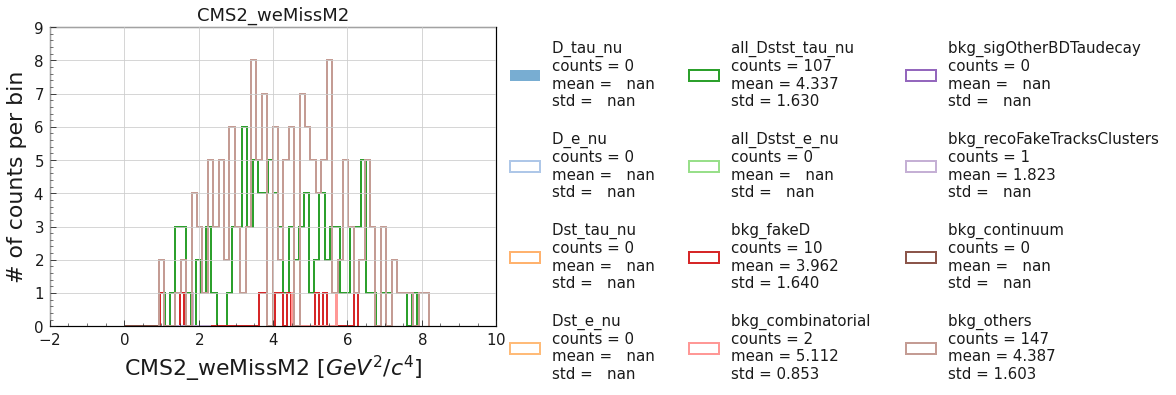

In [13]:
plot_projection('MVA1_output>0.4 and MVA2_1_output>0.2 and B0_roeMbc_my_mask>5.26', 'B0_CMS2_weMissM2')
plt.xlabel("CMS2_weMissM2 $[GeV^2/c^4]$")
plt.ylabel('# of counts per bin')
plt.title('CMS2_weMissM2');
#plt.xlim(-10,10)

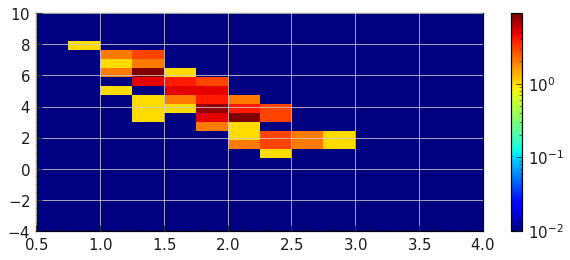

In [14]:
sig_sample = all_Dstst_tau_nu

cut='B0_roeMbc_my_mask>5.26 and MVA1_output>0.4 and MVA2_1_output>0.2'
xedges = np.linspace(0.5, 4, 15)
yedges = np.linspace(-4, 10, 25)
variable_x = 'p_D_l'
variable_y = 'B0_CMS2_weMissM2'

(counts, xedges, yedges) = np.histogram2d(sig_sample.query(cut)[variable_x], 
                                          sig_sample.query(cut)[variable_y],
                                          bins=[xedges, yedges])
counts = counts.T + 0.01
fig,axs=plt.subplots(ncols=1,figsize=(10,4))
X, Y = np.meshgrid(xedges, yedges)
im=axs.pcolormesh(X, Y, counts, cmap='jet', norm=colors.LogNorm())
axs.grid()
fig.colorbar(im)

In [15]:
import json

workspace_file = '/home/belle/zhangboy/R_D/Signal_MC_ROEx1/2d_2channels_workspace.json'
with open(workspace_file, 'r+') as f:
    data = json.load(f)
    data['channels'][0]['samples'][4]['name'] = 'Dstst_tau_nu'
    data['channels'][0]['samples'][4]['data'] = counts.ravel().tolist()
    # counts.ravel()/.reshape(-1) returns a view, counts.flatten() returns a copy (slower)
    f.seek(0)        # <--- should reset file position to the beginning.
    json.dump(data, f, indent=4)
    f.truncate()     # remove remaining part

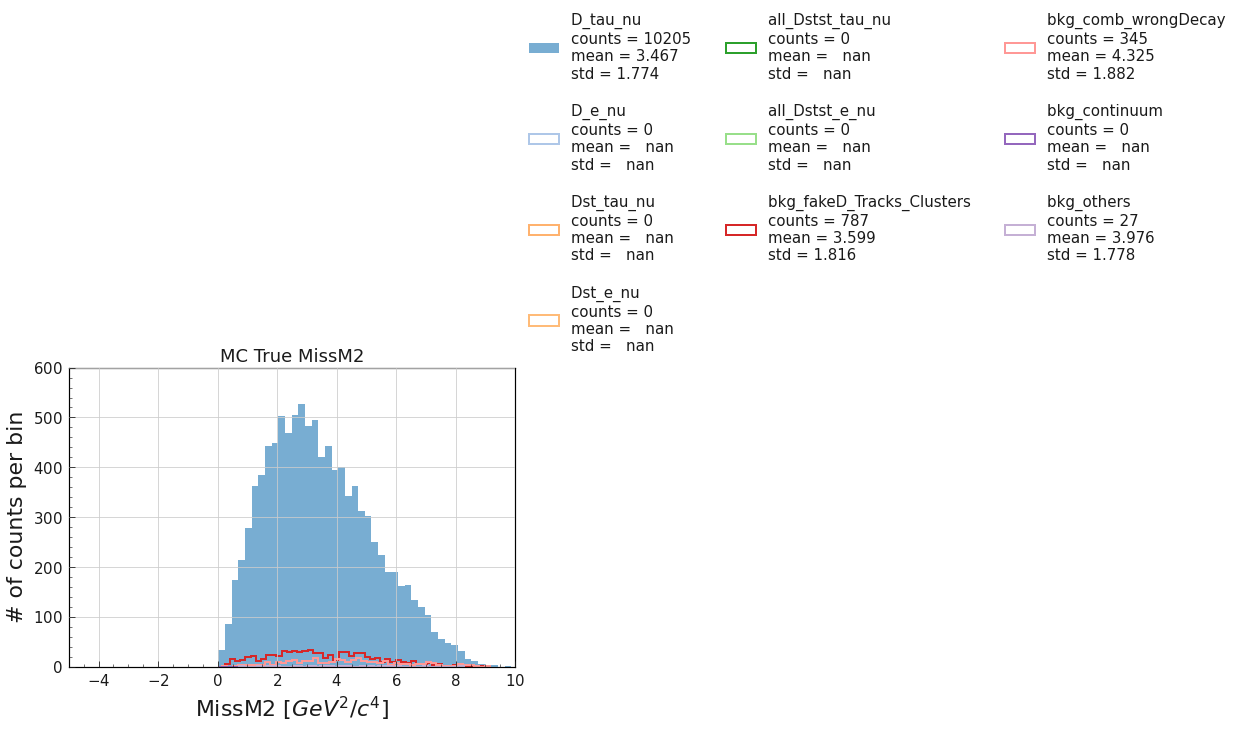

In [32]:
plot_projection('B0_roeMbc_my_mask>5', 'MM2_MC')
plt.xlabel("MissM2 $[GeV^2/c^4]$")
plt.ylabel('# of counts per bin')
plt.title('MC True MissM2');
plt.xlim(-5,10);

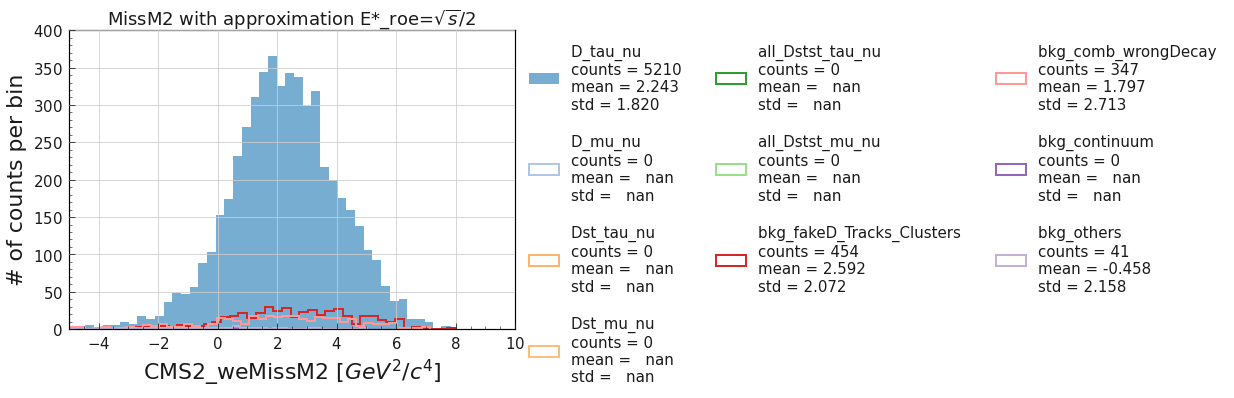

In [34]:
plot_projection('B0_roeMbc_my_mask>5 and -10<B0_CMS2_weMissM2<20', 'B0_CMS2_weMissM2')
plt.xlabel("CMS2_weMissM2 $[GeV^2/c^4]$")
plt.ylabel('# of counts per bin')
plt.title('MissM2 with approximation E*_roe=$\sqrt{s}/2$');
plt.xlim(-5,10);

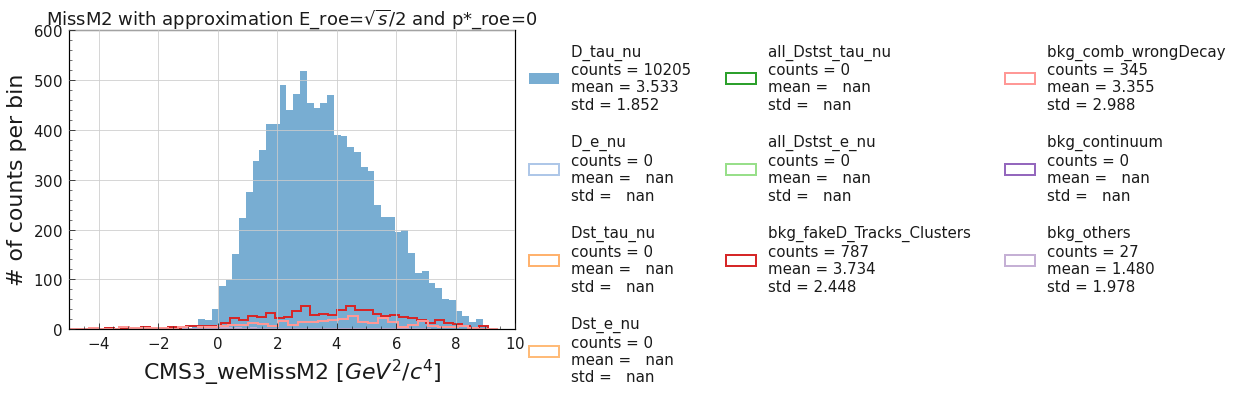

In [30]:
plot_projection('B0_roeMbc_my_mask>5 and -10<B0_CMS2_weMissM2<20', 'B0_CMS3_weMissM2')
plt.xlabel("CMS3_weMissM2 $[GeV^2/c^4]$")
plt.ylabel('# of counts per bin')
plt.title('MissM2 with approximation E*_roe=$\sqrt{s}/2$ and p*_roe=0');
plt.xlim(-5,10);

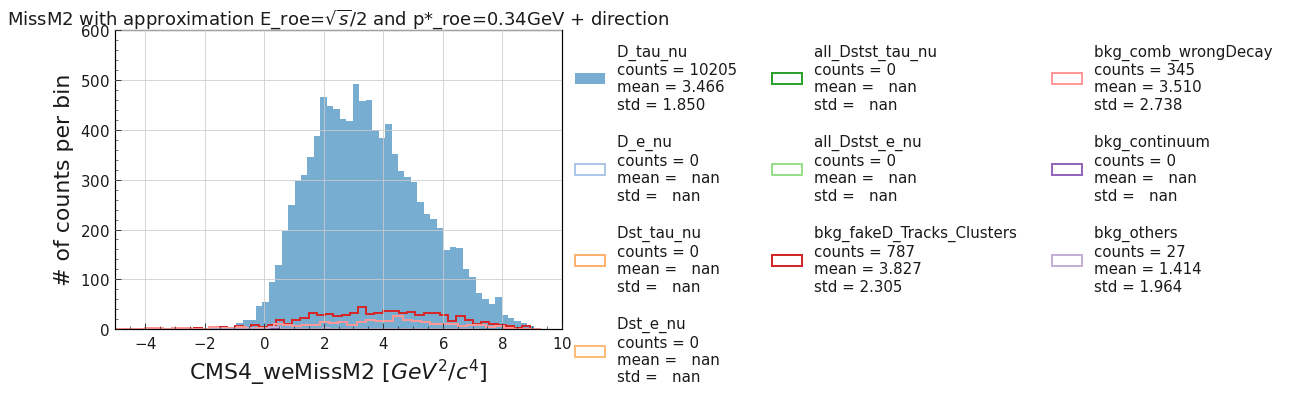

In [31]:
plot_projection('B0_roeMbc_my_mask>5', 'B0_CMS4_weMissM2')
plt.xlabel("CMS4_weMissM2 $[GeV^2/c^4]$")
plt.ylabel('# of counts per bin')
plt.title('MissM2 with approximation E*_roe=$\sqrt{s}/2$ and p*_roe=0.34GeV + direction');
plt.xlim(-5,10);

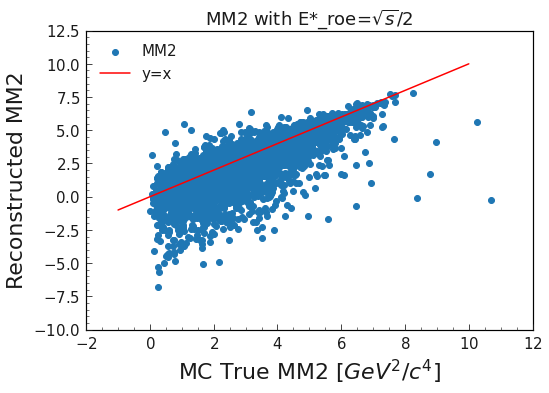

In [38]:
plt.scatter(sig_D_tau_nu.MM2_MC, sig_D_tau_nu.B0_CMS2_weMissM2,label='MM2')
x = np.linspace(-1, 10, 10)
plt.plot(x,x,color='red',label='y=x')
plt.xlabel("MC True MM2 $[GeV^2/c^4]$")
plt.ylabel('Reconstructed MM2')
plt.title('MM2 with E*_roe=$\sqrt{s}/2$')
plt.legend();

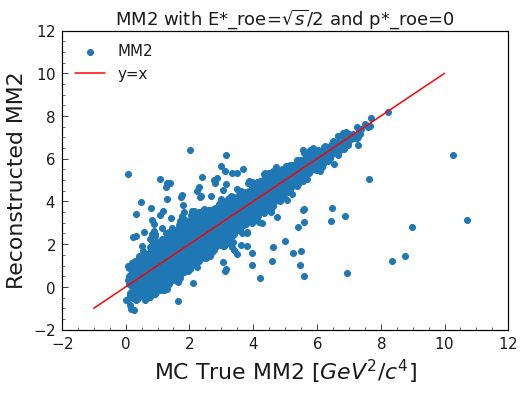

In [39]:
plt.scatter(sig_D_tau_nu.MM2_MC, sig_D_tau_nu.B0_CMS3_weMissM2,label='MM2')
x = np.linspace(-1, 10, 10)
plt.plot(x,x,color='red',label='y=x')
plt.xlabel("MC True MM2 $[GeV^2/c^4]$")
plt.ylabel('Reconstructed MM2')
plt.title('MM2 with E*_roe=$\sqrt{s}/2$ and p*_roe=0')
plt.legend();

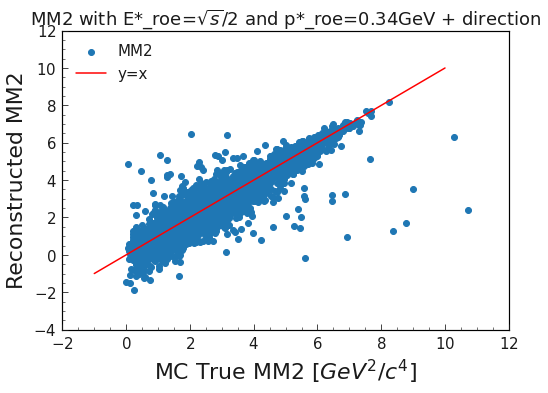

In [40]:
plt.scatter(sig_D_tau_nu.MM2_MC, sig_D_tau_nu.B0_CMS4_weMissM2,label='MM2')
x = np.linspace(-1, 10, 10)
plt.plot(x,x,color='red',label='y=x')
plt.xlabel("MC True MM2 $[GeV^2/c^4]$")
plt.ylabel('Reconstructed MM2')
plt.title('MM2 with E*_roe=$\sqrt{s}/2$ and p*_roe=0.34GeV + direction')
plt.legend();

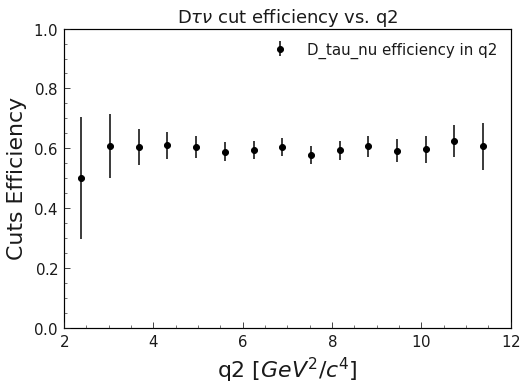

In [8]:
plot_q2_efficiency(cut='2<B0_CMS3_weQ2lnuSimple<13')
plt.xlabel("q2 $[GeV^2/c^4]$")
plt.ylabel('Cuts Efficiency')
plt.title('D$\\tau \\nu$ cut efficiency vs. q2');
plt.xlim(2,12);
plt.ylim(0,1);

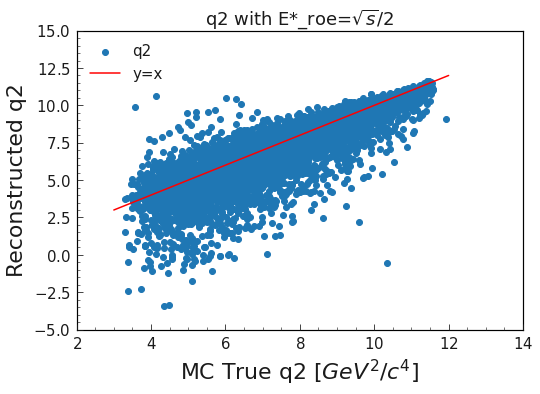

In [35]:
plt.scatter(sig_D_tau_nu.query('q2_MC<13').q2_MC, sig_D_tau_nu.query('q2_MC<13').B0_CMS2_weQ2lnuSimple,label='q2')
x = np.linspace(3, 12, 10)
plt.plot(x,x,color='red',label='y=x')
plt.xlabel("MC True q2 $[GeV^2/c^4]$")
plt.ylabel('Reconstructed q2')
plt.title('q2 with E*_roe=$\sqrt{s}/2$')
plt.legend();

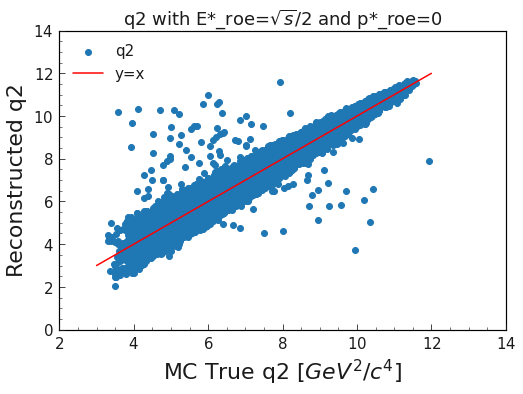

In [36]:
plt.scatter(sig_D_tau_nu.query('q2_MC<13').q2_MC, sig_D_tau_nu.query('q2_MC<13').B0_CMS3_weQ2lnuSimple,label='q2')
x = np.linspace(3, 12, 10)
plt.plot(x,x,color='red',label='y=x')
plt.xlabel("MC True q2 $[GeV^2/c^4]$")
plt.ylabel('Reconstructed q2')
plt.title('q2 with E*_roe=$\sqrt{s}/2$ and p*_roe=0')
plt.legend();

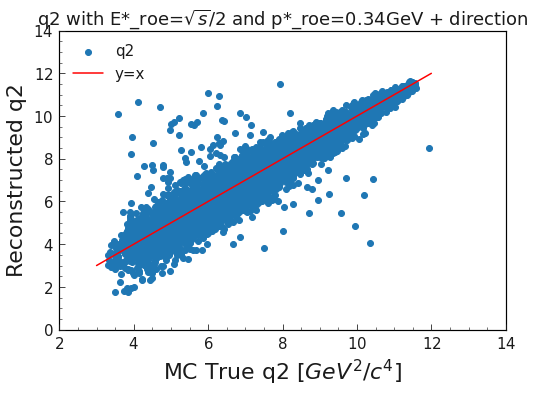

In [37]:
plt.scatter(sig_D_tau_nu.query('q2_MC<13').q2_MC, sig_D_tau_nu.query('q2_MC<13').B0_CMS4_weQ2lnuSimple,label='q2')
x = np.linspace(3, 12, 10)
plt.plot(x,x,color='red',label='y=x')
plt.xlabel("MC True q2 $[GeV^2/c^4]$")
plt.ylabel('Reconstructed q2')
plt.title('q2 with E*_roe=$\sqrt{s}/2$ and p*_roe=0.34GeV + direction')
plt.legend();

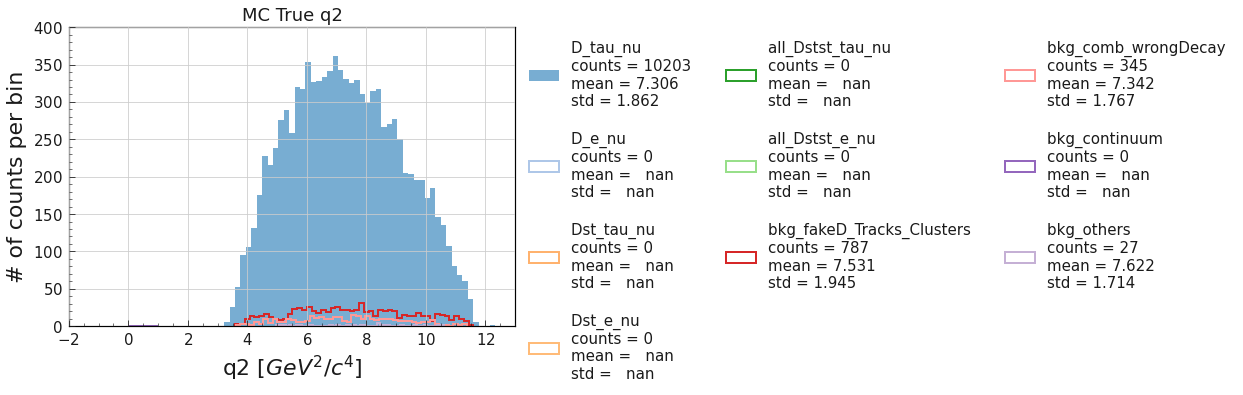

In [40]:
plot_projection('B0_roeMbc_my_mask>5 and q2_MC<13', 'q2_MC')
plt.xlabel("q2 $[GeV^2/c^4]$")
plt.ylabel('# of counts per bin')
plt.title('MC True q2')
plt.xlim(-2,13);

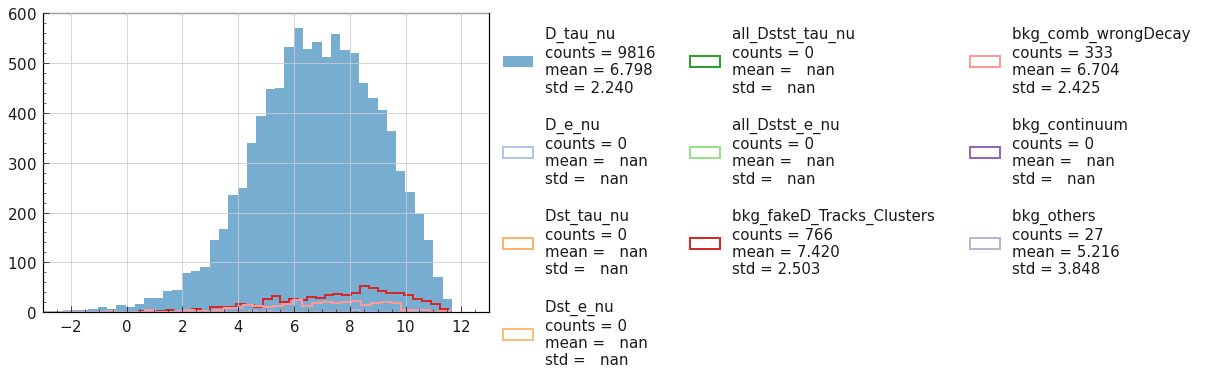

In [30]:
plot_projection('B0_roeMbc_my_mask>5', 'B0_CMS2_weQ2lnuSimple')
plt.xlabel("CMS2_q2 $[GeV^2/c^4]$")
plt.ylabel('# of counts per bin')
plt.title('q2 with approximation E_roe=$\sqrt{s}/2$')
plt.xlim(-3,13);

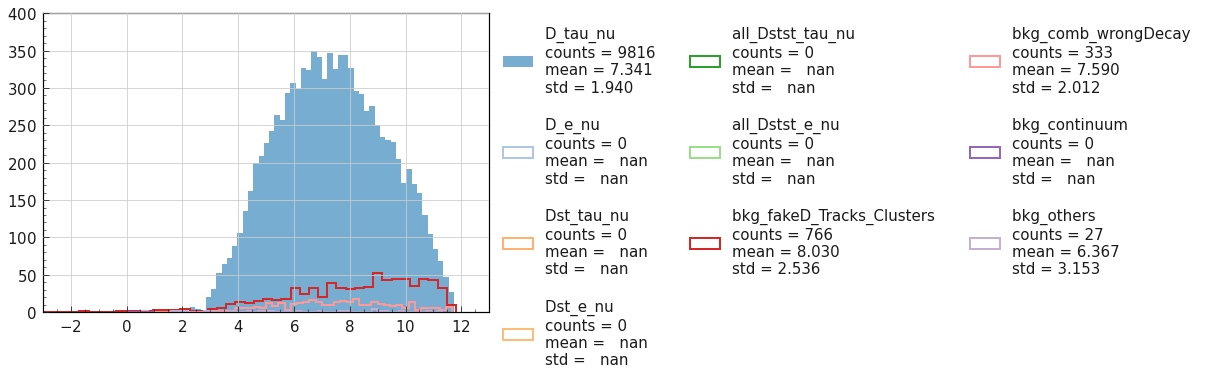

In [31]:
plot_projection('B0_roeMbc_my_mask>5', 'B0_CMS3_weQ2lnuSimple')
plt.xlabel("CMS2_q2 $[GeV^2/c^4]$")
plt.ylabel('# of counts per bin')
plt.title('q2 with approximation E_roe=$\sqrt{s}/2$ and p*_roe=0')
plt.xlim(-2,13);

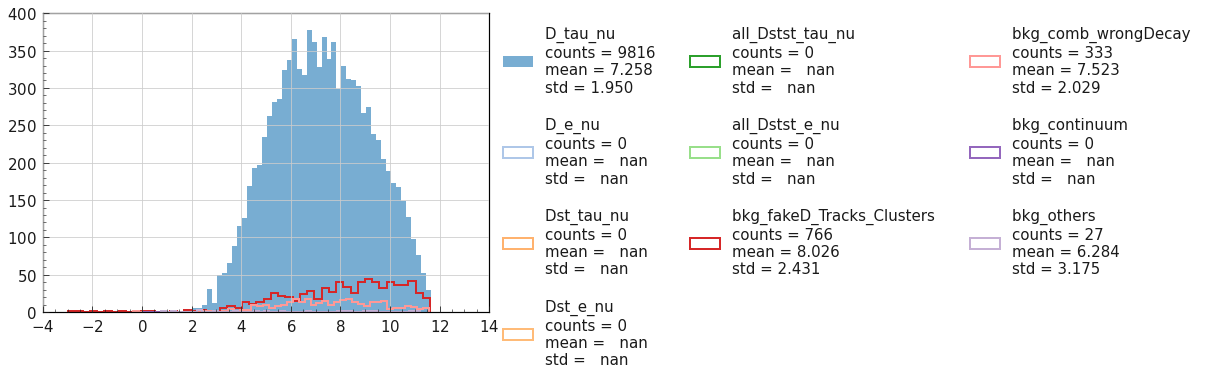

In [32]:
plot_projection('B0_roeMbc_my_mask>5', 'B0_CMS4_weQ2lnuSimple')
plt.xlabel("CMS4_q2 $[GeV^2/c^4]$")
plt.ylabel('# of counts per bin')
plt.title('q2 with approximation E_roe=$\sqrt{s}/2$ and p*_roe=0.34GeV + direction');
plt.xlim(-2,13);

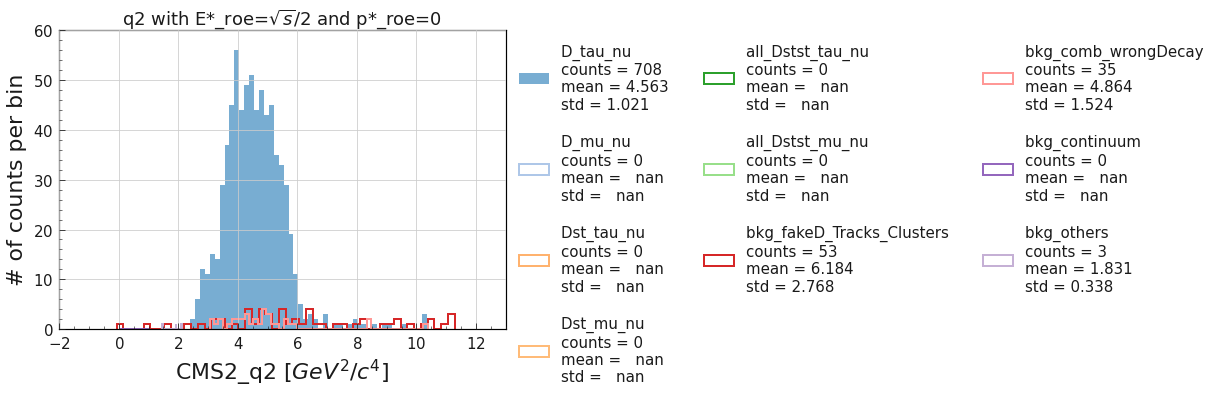

In [8]:
plot_projection('3<q2_MC<5', 'B0_CMS3_weQ2lnuSimple')
plt.xlabel("CMS2_q2 $[GeV^2/c^4]$")
plt.ylabel('# of counts per bin')
plt.title('q2 with E*_roe=$\sqrt{s}/2$ and p*_roe=0')
plt.xlim(-2,13);

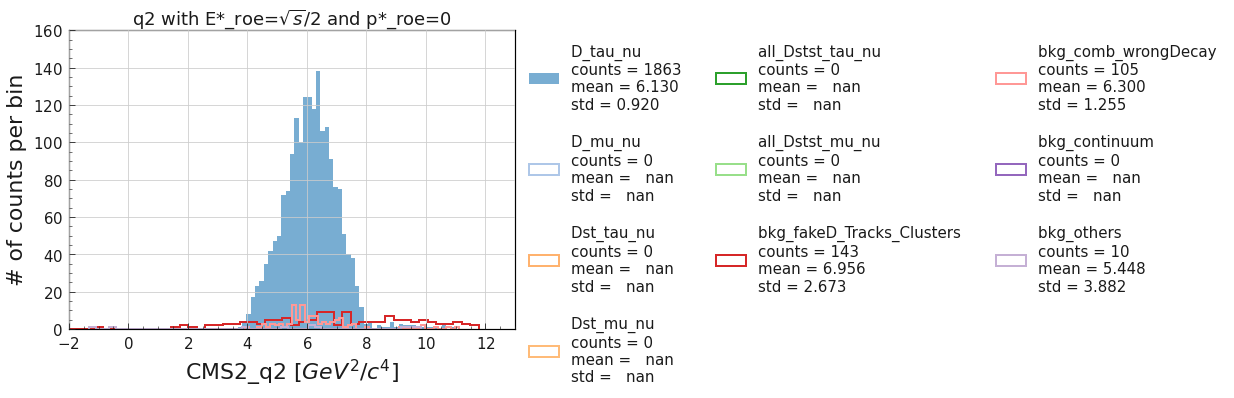

In [9]:
plot_projection('5<q2_MC<7', 'B0_CMS3_weQ2lnuSimple')
plt.xlabel("CMS2_q2 $[GeV^2/c^4]$")
plt.ylabel('# of counts per bin')
plt.title('q2 with E*_roe=$\sqrt{s}/2$ and p*_roe=0')
plt.xlim(-2,13);

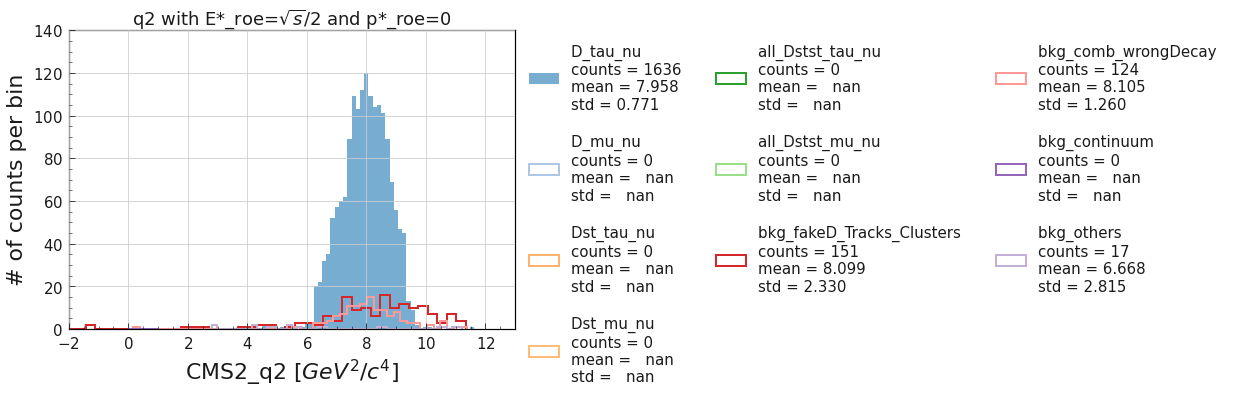

In [10]:
plot_projection('7<q2_MC<9', 'B0_CMS3_weQ2lnuSimple')
plt.xlabel("CMS2_q2 $[GeV^2/c^4]$")
plt.ylabel('# of counts per bin')
plt.title('q2 with E*_roe=$\sqrt{s}/2$ and p*_roe=0')
plt.xlim(-2,13);

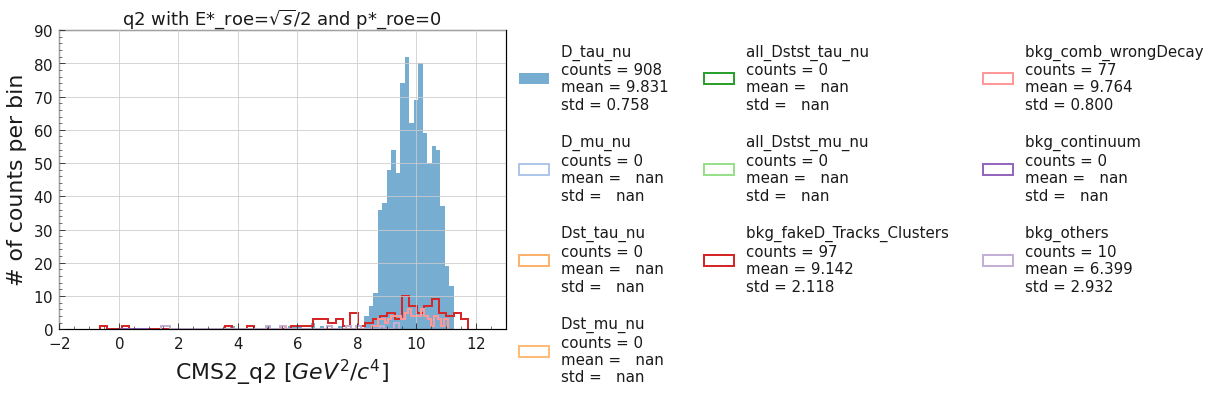

In [11]:
plot_projection('9<q2_MC<11', 'B0_CMS3_weQ2lnuSimple')
plt.xlabel("CMS2_q2 $[GeV^2/c^4]$")
plt.ylabel('# of counts per bin')
plt.title('q2 with E*_roe=$\sqrt{s}/2$ and p*_roe=0')
plt.xlim(-2,13);